<a href="https://colab.research.google.com/github/Viraj-Sonavane/Covid-19-Peak-Predictor-using-ARIMA-LSTM-and-FBProphet-/blob/main/Covid_19_Peak_Predictor_using_ARIMA_LSTM_and_FBProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19-Peak-Predictor-using-ARIMA-LSTM-and-FBProphet
1. Data Source from OUR WORLD in Data GitHub repository.
2. Goal to predict COVID-19 peak using Time Series Analysis
3. Dataset available here: https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-data.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
from matplotlib import dates
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Javascript
from datetime import datetime
from pandas.api.types import is_numeric_dtype
from google.colab import files
import os
import time
import getpass
import statistics
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from pylab import rcParams
import missingno as msno
!pip install geopandas #for map
import geopandas as gpd
from pandas import DataFrame
from pandas import to_datetime

import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 55)

#import sklearn packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import Holt

#Import ARIMA packages
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ADFTest

# Use bokeh to plot predictions
import bokeh.io
bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter


In [2]:
#loading the URL
covid_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
#read the CSV file
cdata = pd.read_csv(covid_url, error_bad_lines=False)


In [3]:
#Number of columns
cdata.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [4]:
#Display all rows
pd.set_option('display.max_rows',None)

In [5]:
#Total rows
cdata.shape

(124675, 65)

In [6]:
#Checking for null values
cdata.isnull().sum()

iso_code                                        0
continent                                    5650
location                                        0
date                                            0
total_cases                                  6733
new_cases                                    6737
new_cases_smoothed                           7751
total_deaths                                17627
new_deaths                                  17474
new_deaths_smoothed                          7751
total_cases_per_million                      7353
new_cases_per_million                        7357
new_cases_smoothed_per_million               8366
total_deaths_per_million                    18234
new_deaths_per_million                      18081
new_deaths_smoothed_per_million              8366
reproduction_rate                           24134
icu_patients                               109450
icu_patients_per_million                   109450
hosp_patients                              107312


In [7]:
#Dropping unrequired columns
cdata.drop(['excess_mortality_cumulative_per_million','excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','human_development_index','hospital_beds_per_thousand','handwashing_facilities','male_smokers','female_smokers','gdp_per_capita','diabetes_prevalence','cardiovasc_death_rate','extreme_poverty','gdp_per_capita','population_density','reproduction_rate','continent'],axis=1, inplace= True)

In [8]:
cdata.head()

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


In [9]:
#Checking columns with 80% null values 
cdata.isnull().sum() >= (119656 * 0.80)

iso_code                                 False
location                                 False
date                                     False
total_cases                              False
new_cases                                False
new_cases_smoothed                       False
total_deaths                             False
new_deaths                               False
new_deaths_smoothed                      False
total_cases_per_million                  False
new_cases_per_million                    False
new_cases_smoothed_per_million           False
total_deaths_per_million                 False
new_deaths_per_million                   False
new_deaths_smoothed_per_million          False
icu_patients                              True
icu_patients_per_million                  True
hosp_patients                             True
hosp_patients_per_million                 True
weekly_icu_admissions                     True
weekly_icu_admissions_per_million         True
weekly_hosp_a

In [10]:
# dropping column with 80% null values
cdata.drop(['icu_patients','icu_patients_per_million','hosp_patients','hosp_patients_per_million','weekly_hosp_admissions','weekly_hosp_admissions_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million'],axis=1,inplace= True)

In [11]:
cdata.head(1)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,18.6,2.581,1.337,64.83


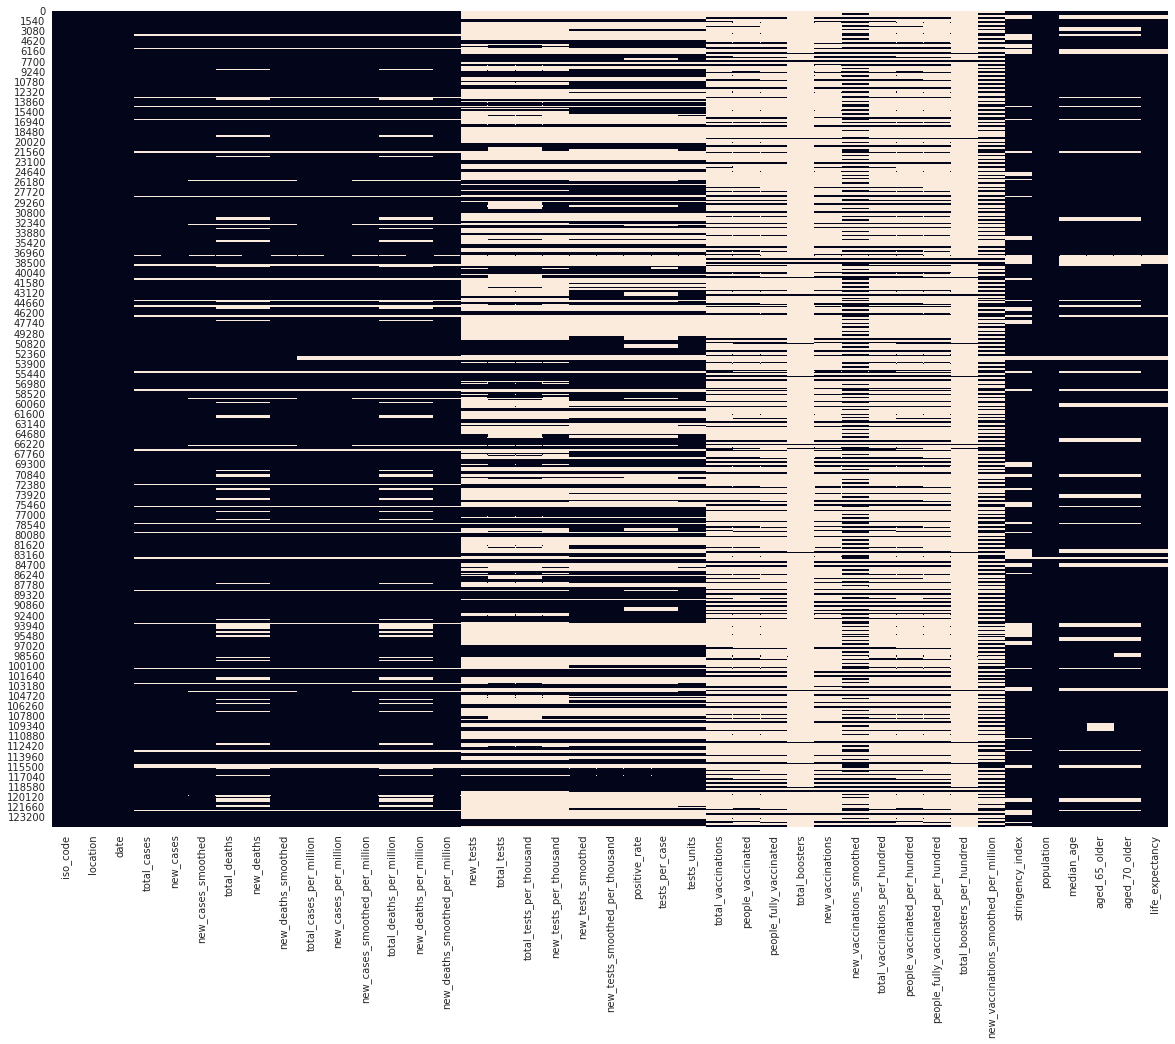

In [12]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [13]:
#Fill NaN values with 0
cdata.fillna(0,inplace=True)


In [14]:
cdata.isnull().sum()

iso_code                                 0
location                                 0
date                                     0
total_cases                              0
new_cases                                0
new_cases_smoothed                       0
total_deaths                             0
new_deaths                               0
new_deaths_smoothed                      0
total_cases_per_million                  0
new_cases_per_million                    0
new_cases_smoothed_per_million           0
total_deaths_per_million                 0
new_deaths_per_million                   0
new_deaths_smoothed_per_million          0
new_tests                                0
total_tests                              0
total_tests_per_thousand                 0
new_tests_per_thousand                   0
new_tests_smoothed                       0
new_tests_smoothed_per_thousand          0
positive_rate                            0
tests_per_case                           0
tests_units

In [15]:
cdata.head(10)

,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,AFG,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,0.0,0.126,0.126,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
1,AFG,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
2,AFG,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
3,AFG,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
4,AFG,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
5,AFG,Afghanistan,2020-02-29,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,39835428.0,18.6,2.581,1.337,64.83
6,AFG,Afghanistan,2020-03-01,5.0,0.0,0.714,0.0,0.0,0.0,0.126,0.000,0.018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
7,AFG,Afghanistan,2020-03-02,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
8,AFG,Afghanistan,2020-03-03,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83
9,AFG,Afghanistan,2020-03-04,5.0,0.0,0.000,0.0,0.0,0.0,0.126,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.78,39835428.0,18.6,2.581,1.337,64.83


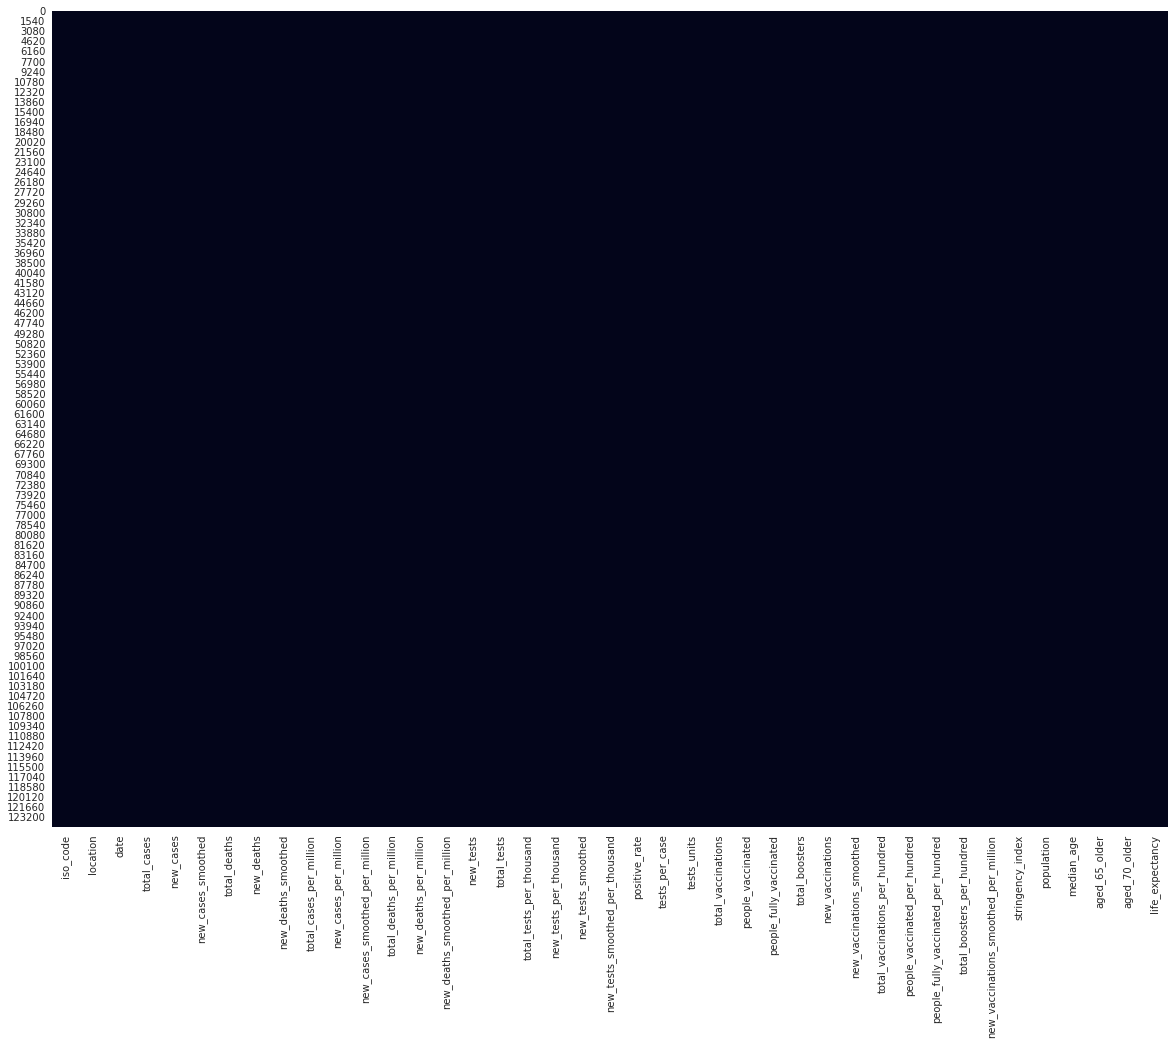

In [16]:
plt.subplots(figsize=(20,15))
sns.heatmap(cdata.isnull(), cbar=False)

In [17]:
cdata['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

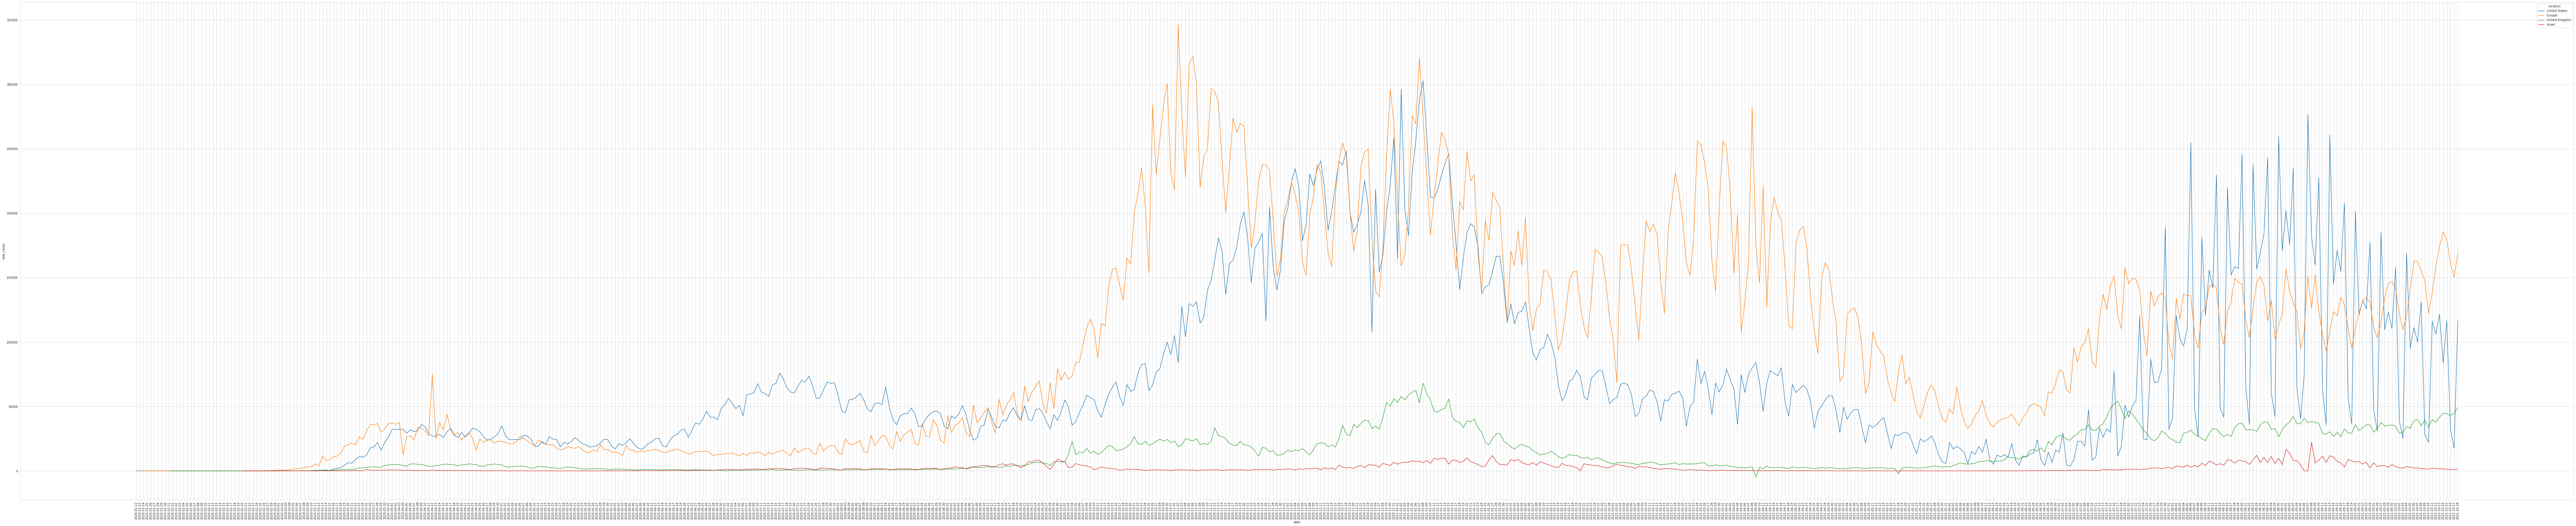

In [18]:
plt.figure(figsize=(150,30))
sns.lineplot(data=cdata[cdata['location'].isin(['United States','Israel','United Kingdom','Europe'])].sort_values(by='date'), x='date', y='new_cases',hue='location')
plt.xticks(rotation = 'vertical')
plt.show()

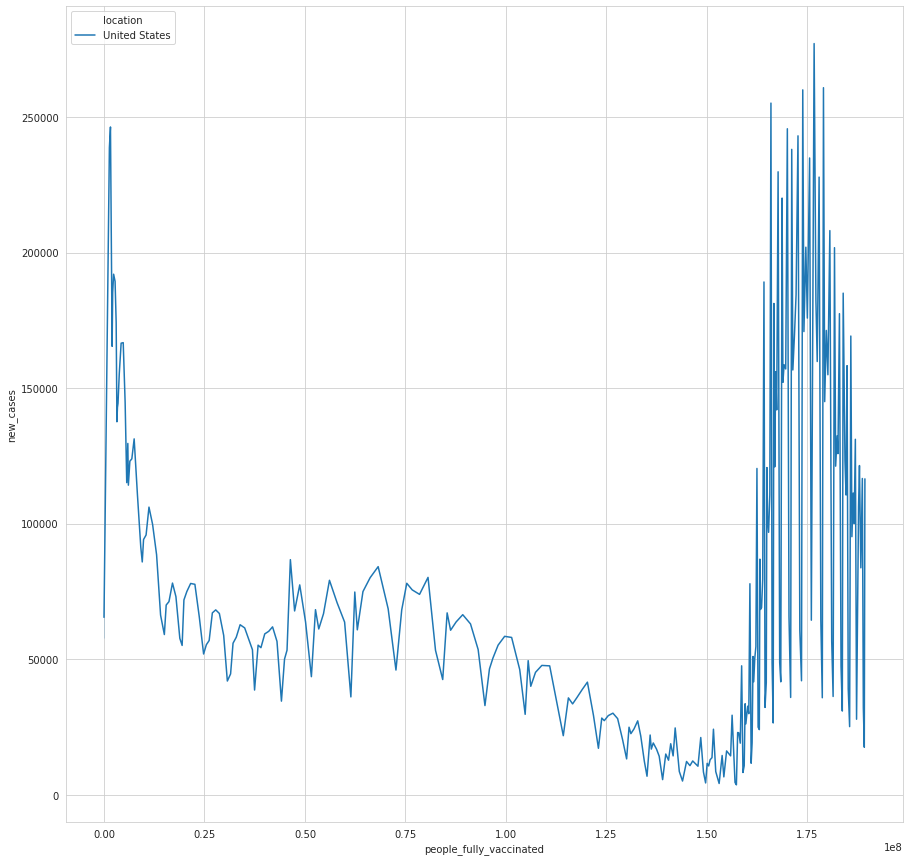

In [19]:
plt.figure(figsize=(15,15))
sns.lineplot(data=cdata[cdata['location'].isin(['United States'])].sort_values(by='date'), x='people_fully_vaccinated', y='new_cases',hue='location')
plt.show()

In [20]:
#Using geopandas datset naturalearth lowres
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
8,260580739,Asia,Indonesia,IDN,3028000.0,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


In [21]:
#We will join both the data for covid and world map and join it on iso_code
merged = world.set_index('iso_a3').join(cdata.set_index('iso_code')).reset_index()


In [22]:
merged.head(3)

,index,pop_est,continent,name,gdp_md_est,geometry,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,median_age,aged_65_older,aged_70_older,life_expectancy
0,-99,5320045,Europe,Norway,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-99,67106161,Europe,France,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-99,265100,Asia,N. Cyprus,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def graph_world(feature):
    #whichever data we wish to map we will send in feature
    to_be_mapped = feature
    vmin, vmax = 0,100
    fig, ax = plt.subplots(1, figsize=(25,25))

    merged.plot(column=to_be_mapped, cmap='viridis', linewidth=0.8, ax=ax, edgecolors='0.8' , legend=True,
                legend_kwds={'label': "stringency_index", 'orientation': "horizontal"})
    ax.set_title('Covid_Restriction', fontdict={'fontsize':20})
    

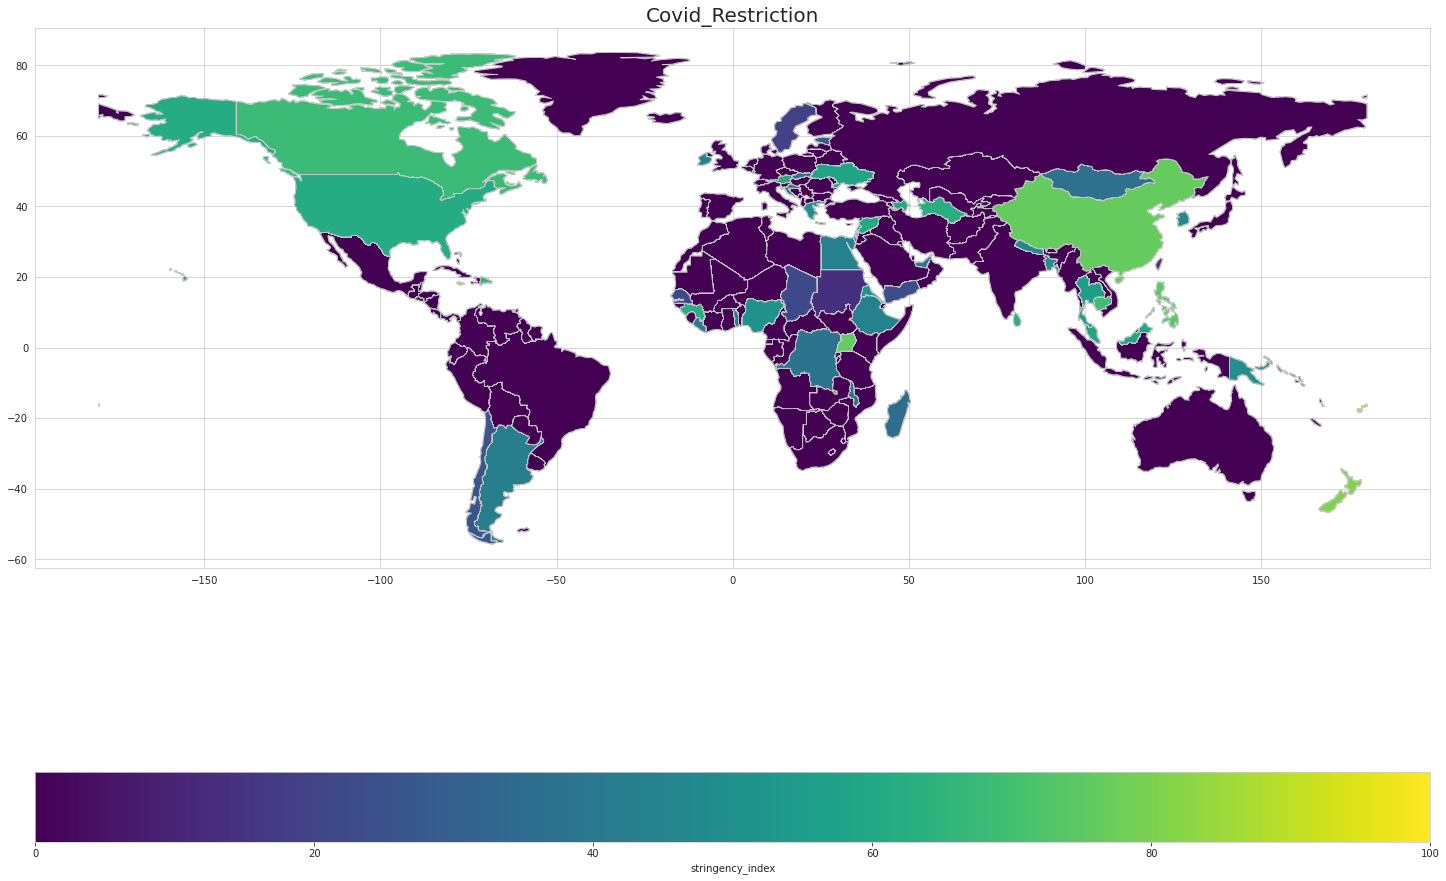

In [24]:
graph_world('stringency_index')

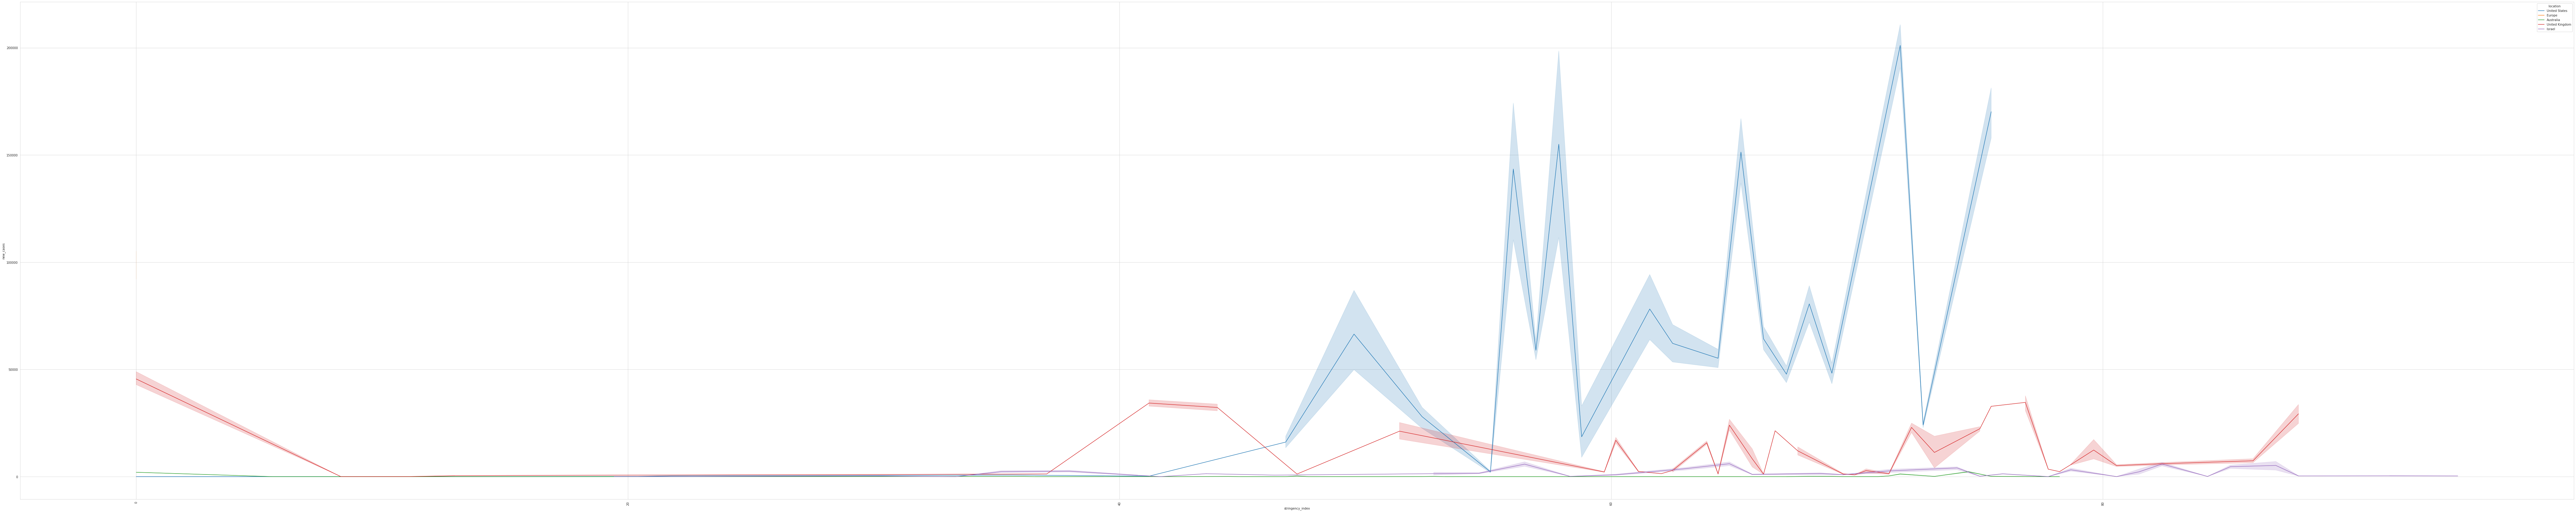

In [25]:
plt.figure(figsize=(150,30))
sns.lineplot(data=cdata[cdata['location'].isin(['United States','Israel','United Kingdom','Europe','Australia'])].sort_values(by='date'), x='stringency_index', y='new_cases',hue='location')
plt.xticks(rotation = 'vertical')
plt.show()

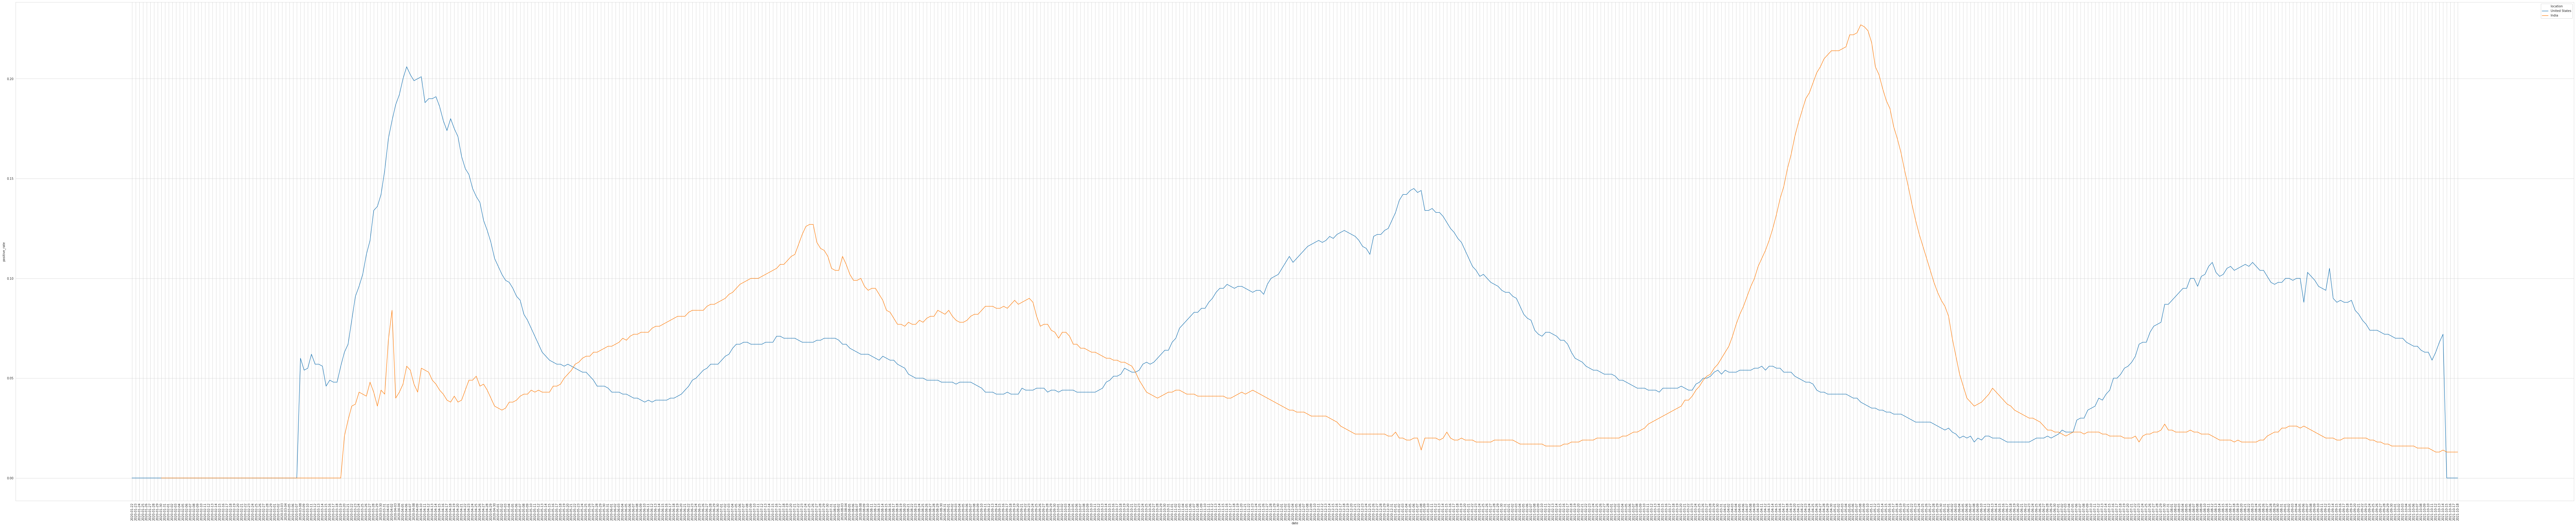

In [26]:
plt.figure(figsize=(150,30))
sns.lineplot(data=cdata[cdata['location'].isin(['United States','India'])].sort_values(by='date'), x='date', y='positive_rate',hue='location')
plt.xticks(rotation = 'vertical')
plt.show()

# FBProphet Forecast

In [27]:
def forecast(nation):
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.columns = ['ds','y']
  model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(data)
  future = model.make_future_dataframe(periods=365, freq='D')
  pred = model.predict(future)
  model.plot(pred);
  model.plot_components(pred);


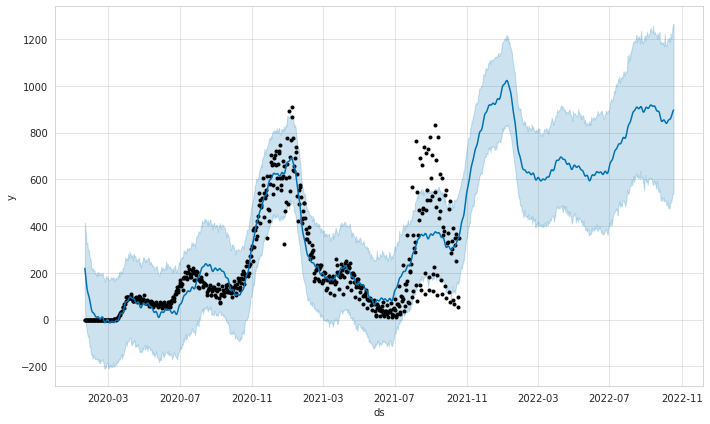

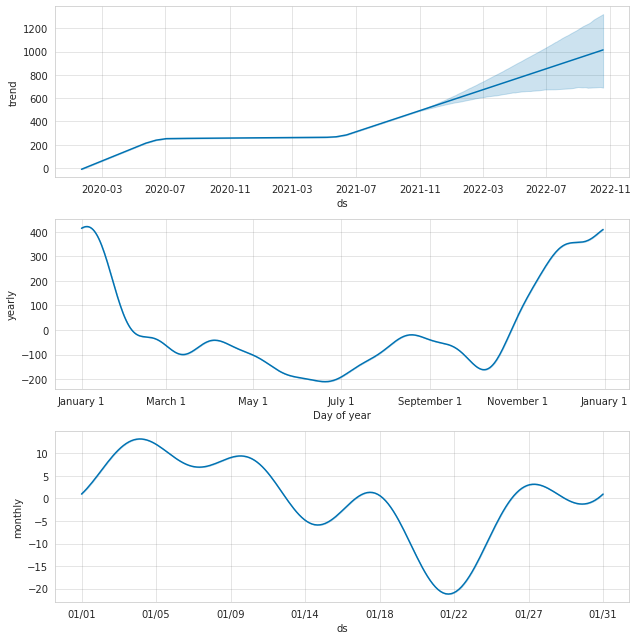

In [28]:
m = forecast('United States');

In [29]:
#future = list()
#for i in range(1, 13):
#  date = '2021-%01d' % i
#  future.append([date])
#for i in range(1, 13):
#  date = '2022-%12d' % i
#  future.append([date])
#future = DataFrame(future)
#future.columns = ['ds']
#future['ds']= to_datetime(future['ds'])

### FBProphet forecast with regressor 

In [30]:
def forecast2(nation):
  data2 = cdata[cdata['location'].isin([nation])].sort_values(by="date").rename(columns={'new_cases_per_million':'y','date':'ds'})
  model2 = Prophet(weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  temp = cdata[cdata['location'].isin([nation])].sort_values(by="date")

  def positive_rate(ds):
    date = (pd.to_datetime(ds)).date()
    return (temp['positive_rate']).values[0]

  def stringency_index(ds):
    date = (pd.to_datetime(ds)).date()
    return (temp['stringency_index']).values[0]    

  #model2.add_regressor('positive_rate')
  model2.add_regressor('stringency_index')
  model2.fit(data2)

  future2 = model2.make_future_dataframe(periods=365)
  #future2['positive_rate'] = future2['ds'].apply(positive_rate)
  future2['stringency_index'] = future2['ds'].apply(stringency_index)
  
  pred2 = model2.predict(future2)
  model2.plot(pred2);
  
  #future2['positive_rate'] = temp['positive_rate'] 
  #future2['people_vaccinated_per_hundred'] = temp['people_vaccinated_per_hundred']

In [31]:
def forecast3(nation):
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.columns = ['ds','y']
  model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(data)
  future = model.make_future_dataframe(periods=365, freq='D')
  pred = model.predict(future)
  model.plot(pred);
  

In [32]:
clist = cdata.sort_values(by="new_cases_per_million",ascending=False)
clist2 = clist.sort_values(by="people_fully_vaccinated_per_hundred",ascending=False)
clist2 = clist.sort_values(by="positive_rate",ascending=False)
clist2['location'].head(2000).unique()

array(['Uganda', 'Papua New Guinea', 'Palestine',
       'Bosnia and Herzegovina', 'Gabon', 'Bolivia', 'Peru', 'Botswana',
       'Senegal', 'Madagascar', 'Iran', 'Mexico', 'Guatemala',
       'Dominican Republic', 'Namibia', 'Armenia', 'Ukraine', 'Poland',
       'Argentina', 'Trinidad and Tobago', 'Tunisia', 'Mongolia', 'Nepal',
       'Paraguay', 'Democratic Republic of Congo', 'Serbia', 'Spain',
       'Ecuador', 'Costa Rica', 'Indonesia', 'Jamaica', 'Panama',
       'Albania', 'Bulgaria', 'North Macedonia', 'Sri Lanka', 'Timor',
       'Myanmar', 'Fiji', 'Thailand', 'Malawi', 'Chile', 'Croatia',
       'Oman', 'Mozambique', 'Hungary', 'United Kingdom', 'Bangladesh',
       'Colombia', 'Belgium', 'South Africa'], dtype=object)

In [33]:
#data = cdata[cdata['location'].isin(['United Kingdom'])].sort_values(by="date")[['date',"new_cases_per_million"]]
#data.set_index('date', inplace=True)
#c = data.loc['0':'2021-04-30']
#df = c.reset_index()
#df.columns = ['ds','y']
#model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
#model.fit(df)
#future = model.make_future_dataframe(periods=365, freq='D')
#pred = model.predict(future)
#model.plot(pred);

In [56]:
def forecast4(nation):
  data = cdata[cdata['location'].isin([nation])].sort_values(by="date")[['date',"new_cases_per_million"]]
  data.set_index('date', inplace=True)
  c = data.loc['0':'2021-04-30']
  df = c.reset_index()
  df.columns = ['ds','y']
  model = Prophet(daily_seasonality=False,weekly_seasonality=False,yearly_seasonality=True,interval_width=0.95)
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(df)
  future = model.make_future_dataframe(periods=365, freq='D')
  pred = model.predict(future)
  model.plot(pred);

In [37]:
ndata2.head(2)

,new_cases_per_million
Date,
2020-01-22,0.000
2020-01-23,0.012


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


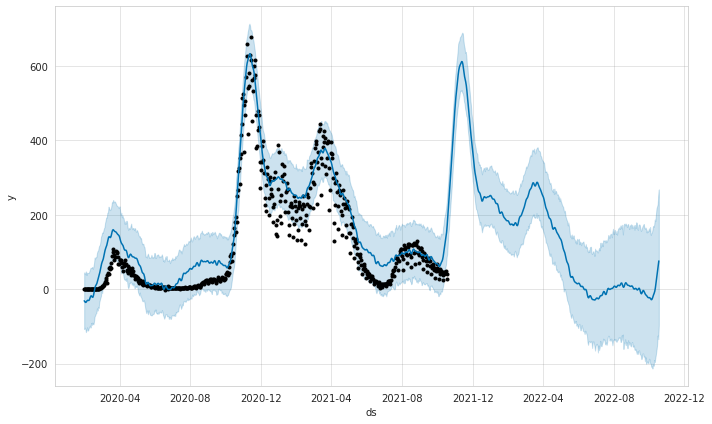

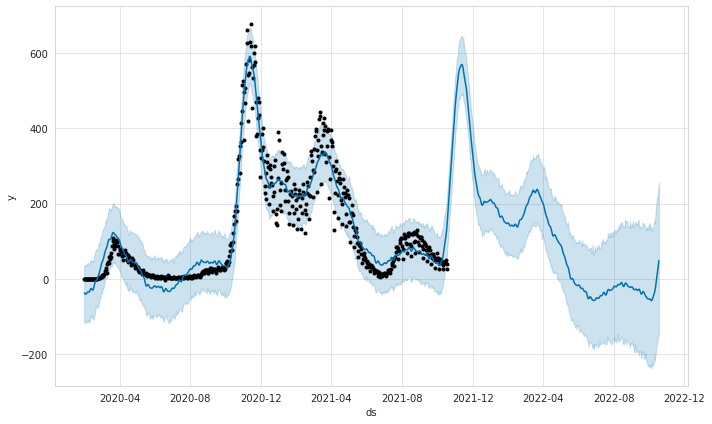

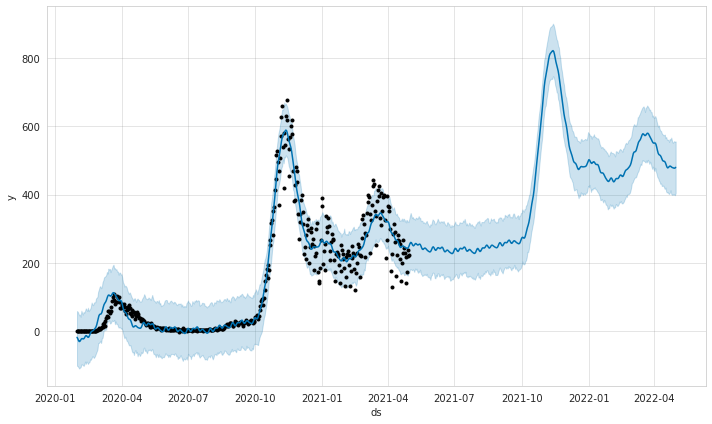

In [57]:
forecast2('Italy')
forecast3('Italy')
forecast4('Italy')
